In [2]:
from glob import glob
import baltic as bt
from matplotlib import pyplot as plt
%matplotlib inline
import random
import pickle

In [29]:
def is_monophyletic(node, trait):
    n_states = len(set([k.traits[trait] for k in tree.traverse_tree(node, include_all=True) if isinstance(k, bt.leaf)]))
    if n_states == 1:
        return True
    else:
        return False

def get_label(leaf):
    name = leaf.name
    if len(name.split('|')) > 3:
        host = name.split('|')[2]
        strain = name.split('|')[4]
    else:
        host = name.split('|')[0]
        strain = name.split('|')[1]
    if host not in ['Cercopithecus_cephus', 'Mandrillus_sphinx', 'Homo_sapiens']:
        return strain_names[host]
    elif host == 'Homo_sapiens':
        if leaf.parent.traits['host'] == 'Cercocebus_atys':
            label = 'HIV-2'
        else:
            label = 'HIV-1'
    elif host == 'Mandrillus_sphinx':
        if 'MND-1' in strain:
            label = 'SIVmnd-1'
        elif 'MND-2' in strain:
            label = 'SIVmnd-2'
        else:
            label = 'SIVmnd'
    else:
        if 'MUS-1' in strain:
            label = 'SIVmus-1'
        elif 'MUS-2' in strain:
            label = 'SIVmus-2'
        elif 'MUS-3' in strain:
            label = 'SIVmus-3'
        else:
            label = 'SIVmus'
    return label


def desaturate(color, s): # Adjust (R,G,B,A) tuple by saturation proportion s
    if s > 0.85:
        return color
    else:
        s = s/2.0
        i = [ float(c)*(float(s)) for c in color[:3]]
        i.append(s)
    return tuple(i)
        
def plot_tree(cur_tree, ax, segmentlabel):
    branchWidth = 5
    maxW = []
    maxX,maxY = 0.0, 0.0
    for t in trees.values():
        maxW += [ k.width for k in t.Objects if isinstance(k,bt.clade) ]
    if maxW != []:
        maxW = float(max(maxW))

    for k in cur_tree.Objects: ## iterate over branches
        x=k.height ## or use absolute time instead
        y=k.y*1.1 ## get y position from .drawTree that was run earlier, but could be anything else
        xp=k.parent.height ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x    
        maxX = max(x, maxX)
        maxY = max(y, maxY)

        if k.traits.has_key('host') and k.traits.has_key('host.prob'):
            c_desat=desaturate(colors[k.traits['host']], k.traits['host.prob']) ## can be discrete too
            c = colors[k.traits['host']]
        else:
            c, c_desat='k', 'k'
        if k.branchType=='leaf': ## if leaf...
            label = get_label(k)
            s=80 ## tip size can be fixed
            ax.text(cur_tree.treeHeight+0.05,y,label, size=24)
            if isinstance(k, bt.clade):
                left, right = x, cur_tree.treeHeight
                width = max(k.width / maxW, 0.06)

                points = [[left, y], [right,y+0.5*width], [right,y-0.5*width]]
                ax.add_patch(plt.Polygon(points, facecolor=c, zorder=8, edgecolor=None) )

            else:
                ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                ax.scatter(x,y,s=s+0.7*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node): ## if node...
            ax.plot([x,x],[k.children[-1].y*1.1,k.children[0].y*1.1],lw=branchWidth,color=c_desat,ls='-',zorder=9) ## plot vertical bar

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c_desat,ls='-',zorder=9) ## always plot branch
    ax.text(0.0, maxY+1.2, '%s'%segmentlabel, fontsize=48, fontweight='bold')
#     ax.plot([0.0,0.5],[-0.8,-0.8], lw=branchWidth, color='gray', ls='-')
#     ax.text(0.0, -1.2, '0.5 subs/site', fontsize=44)

    ax.set_ylim(-2.5,maxY+2.5) ## set y limits
    ax.set_xlim(0.0, maxX+1.0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='x',labelsize=0,size=0)
    ax.tick_params(axis='y',labelsize=0,size=0)

In [30]:
treefiles = glob('/Users/Sidney/Dropbox/siv-manuscript/beast/main/discreteTraits/trees/*.mcc')
treefiles.sort(key=lambda x: int(x.split('/')[-1].split('.')[0].split('_')[1]))

trees = { i:bt.loadNexus(treefile, absoluteTime=False) for i,treefile in enumerate(treefiles)}

strain_names = pickle.load(open('../strain_names.p', 'rb'))
common_names = pickle.load(open('../../data/hosts/common_names.p', 'rb'))
sizes = pickle.load(open('../sizes.p', 'rb'))
colors = pickle.load(open('../colors.p', 'rb'))

genes = {1: "(1) - 3' LTR, gag", 2: "(2) - gag", 3: "(3) - gag, pol", 4: "(4) - pol", 
        5: "(5) - pol", 6: "(6) - pol, vif", 7: "(7) - vif, vpr, tat", 8: "(8) - tat, rev, vpu, env", 
        9: "(9) - env", 10: "(10) - env", 11: "(11) - env, tat, rev", 12: "(12) - env, rev, nef, 5' LTR"}


for tree in trees.values():
    for n in tree.nodes:
        if n.parent.index =='Root' or is_monophyletic(n.parent, 'host'):
            continue
        elif is_monophyletic(n, 'host'):
            try:
                strain = [i for i in n.children if i.branchType=='leaf'][0].name.split('|')[4]
            except:
                strain = ''
            host = n.traits['host']
            new_name = '%s|%s|%d'%(n.traits['host'], strain, random.randint(500,1000))
            tree.collapse(n, new_name)
    tree.drawTree()


Tree height: 1.963447
Tree length: 32.229776

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 287 (143 nodes and 144 leaves)


Tree height: 1.159859
Tree length: 24.272858

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 279 (139 nodes and 140 leaves)


Tree height: 1.195063
Tree length: 31.440039

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 223 (111 nodes and 112 leaves)


Tree height: 0.764629
Tree length: 24.019941

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 231 (115 nodes and 116 leaves)


Tree height: 1.038745
Tree length: 36.413585

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 453 (226 nodes and 227 leaves)



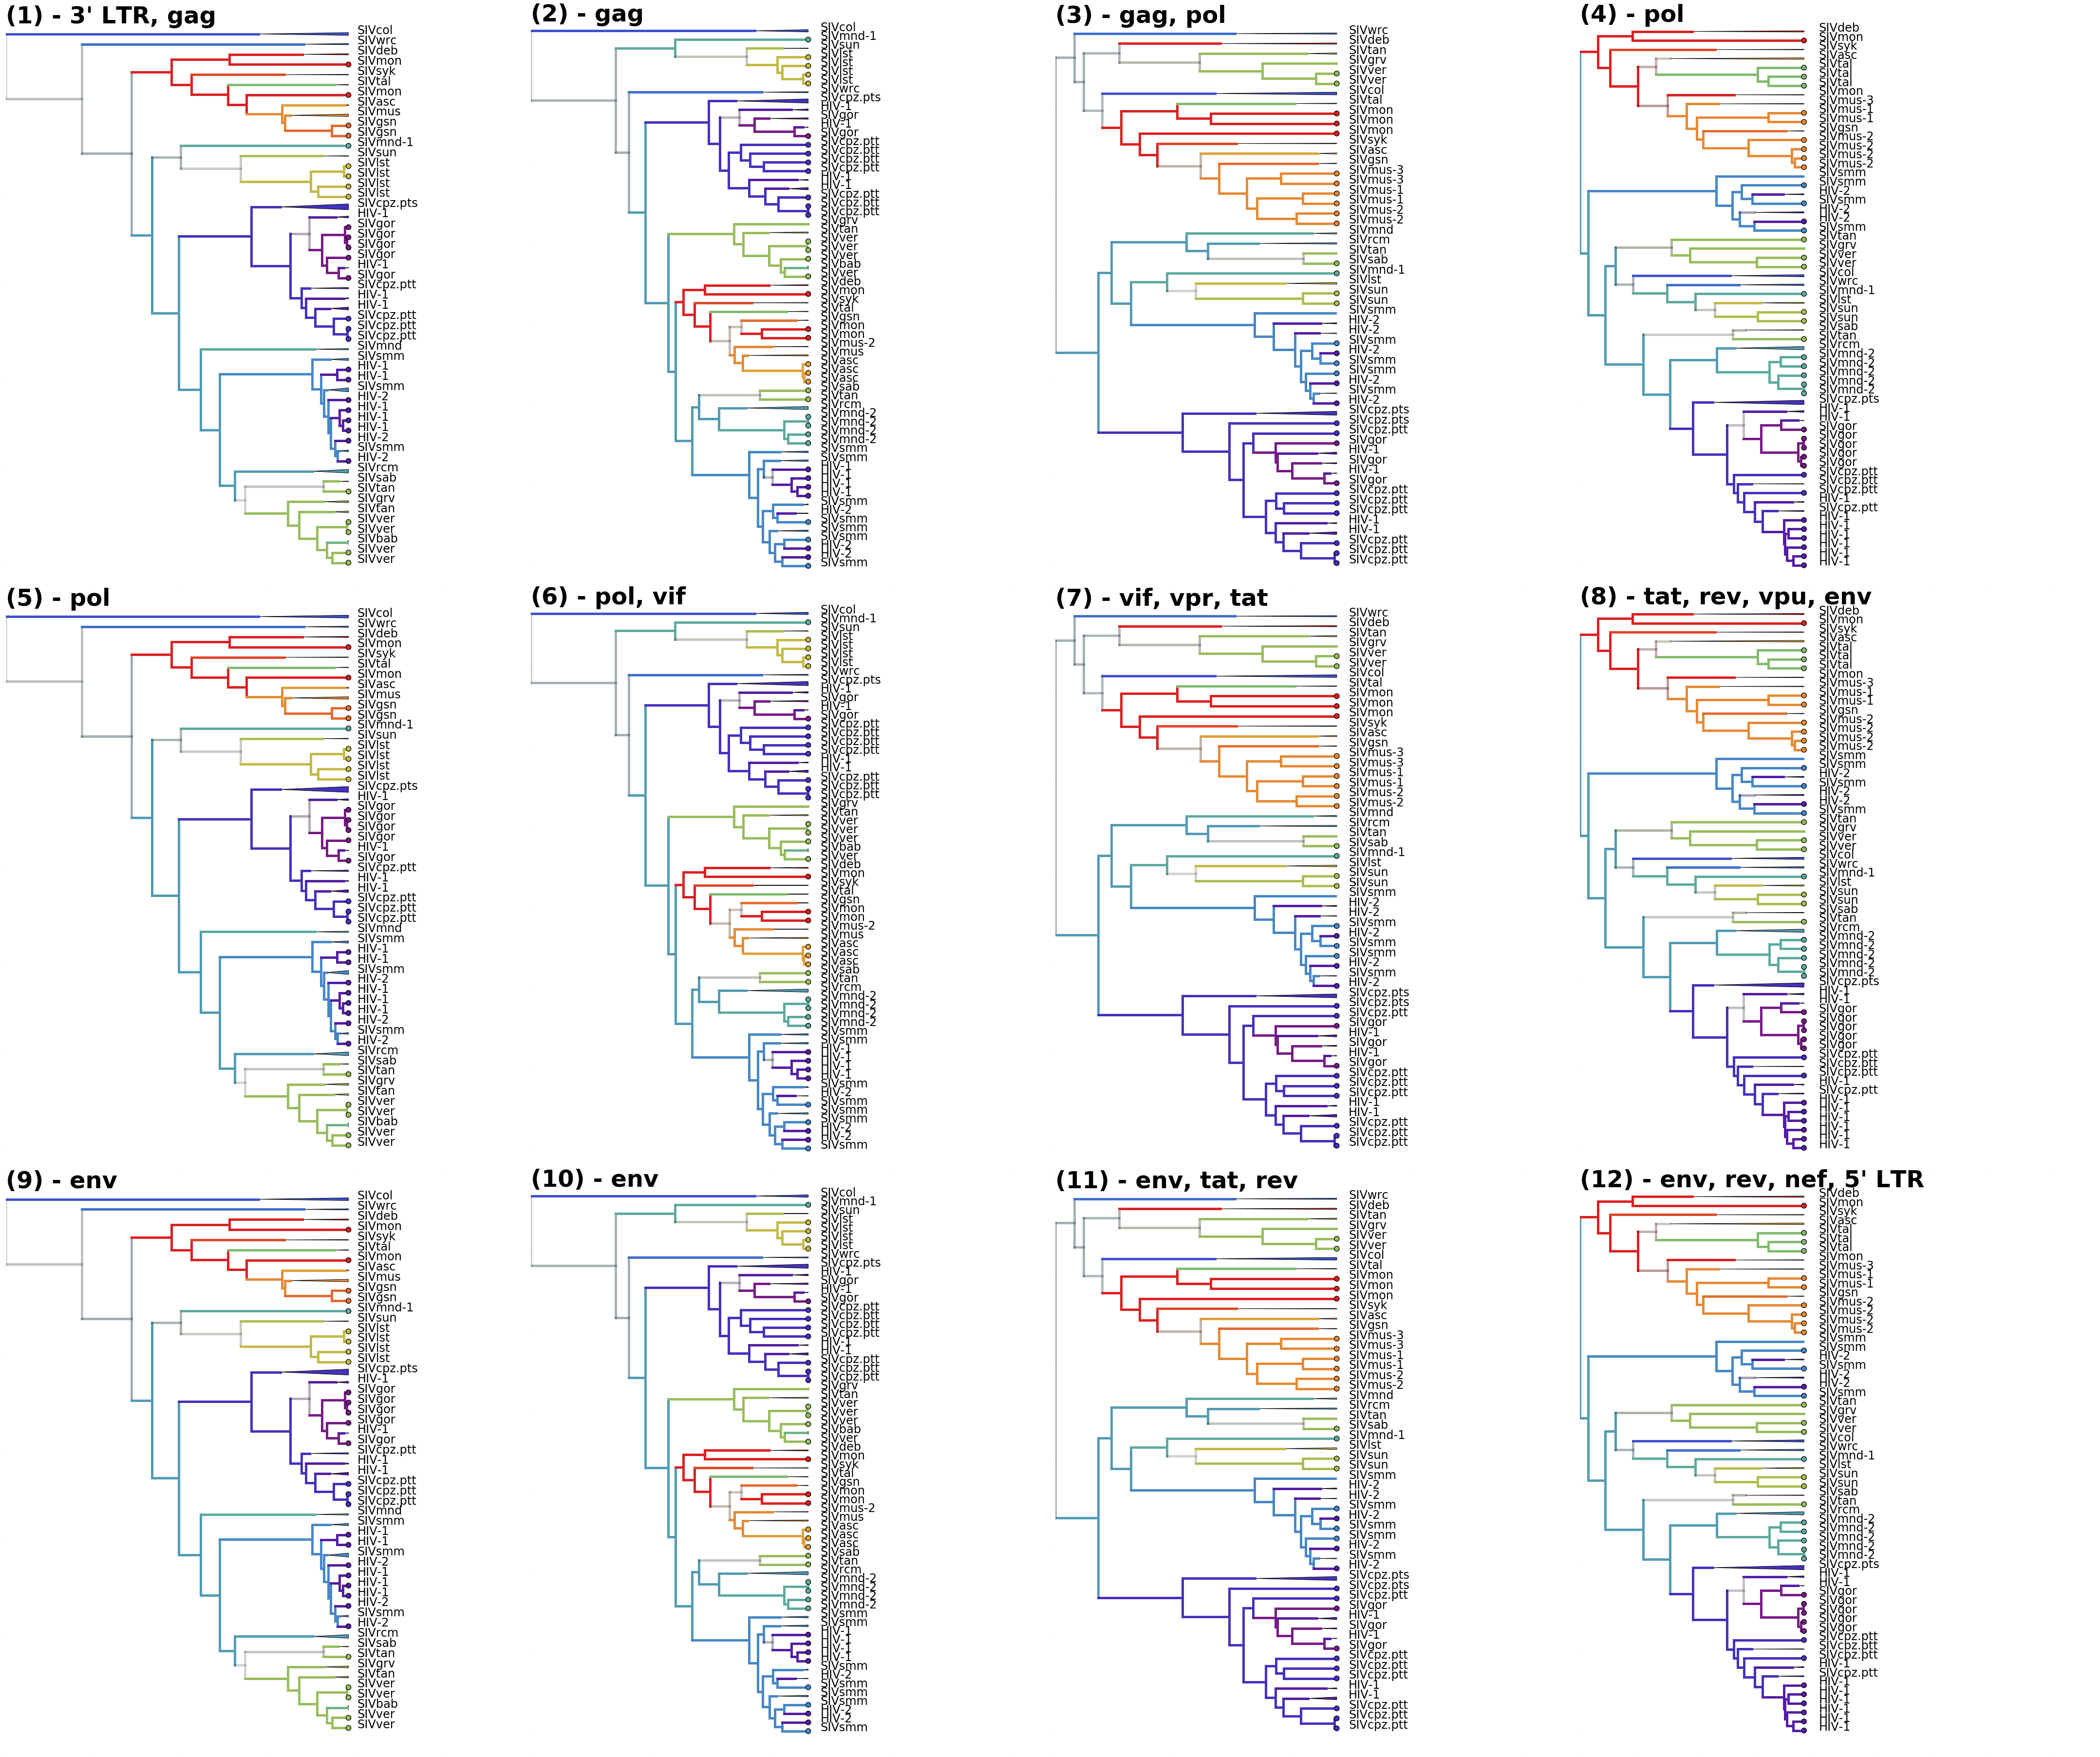

In [31]:
fig, axes = plt.subplots(3, 4, figsize=(60,50))

treelist = [ trees[i] for i in range(len(trees)) ]
segmentNumber = 1

for row in axes:
    for treeObject, axis in zip(treelist, row):
        axis=plot_tree(treeObject, axis, genes[segmentNumber])
        segmentNumber += 1
plt.tight_layout()
plt.show()


### Figure S5: Maximum clade credibility trees for each of the 12 GARD-identified genomic segements of the lentiviral genome  
Tips are color coded by known host state; branches and internal nodes are color coded by inferred host state, with color saturation indicating the confidence of these assignments. Monophyletic clades of viruses from the same lineage are collapsed, with the triangle width proportional to the number of represented sequences.